# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from matplotlib_venn import venn2
from datetime import datetime

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# install yfinance
%pip install yfinance

import yfinance as yf

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.


# Reading and Cleaning Data

I import a csv file containing the companies of the C25 index, a yfinance ticker and the share of female board members in each company.

In [31]:
# read file
C25F = pd.read_csv('C25F.csv')

# sort values from highest to lowest for later use
C25F = C25F.sort_values(by =['femaleboard'], ascending=False)

# reset index
C25F = C25F.reset_index(drop=True)

# display data
C25F.head()

,company,femaleboard,yfinanceticker
0,GN STORE NORD,66.67,GN.CO
1,PANDORA,57.14,PNDORA.CO
2,CHR. HANSEN HOLDING,50.00,CHR.CO
3,COLOPLAST,50.00,COLO-B.CO
4,GENMAB,50.00,GMAB.CO


In [32]:
# create a list from yfinance Ticker
C25F_tickers = list(C25F['yfinanceticker'])

In [33]:
# get historical market data
hist_mark = yf.download(C25F_tickers, start = '2020-03-01', end = '2023-04-01', interval = '1mo')

# get adjusted close for each stock
hist_mark = hist_mark['Adj Close']

# change dates
hist_mark.index = hist_mark.index.strftime("%m-%y")

# display dataframe
hist_mark.head()


[*********************100%***********************]  26 of 26 completed


,AMBU-B.CO,BAVA.CO,CARL-B.CO,CHR.CO,COLO-B.CO,DANSKE.CO,DEMANT.CO,DSV.CO,FLS.CO,GMAB.CO,...,NETC.CO,NOVO-B.CO,NZYM-B.CO,ORSTED.CO,PNDORA.CO,RBREW.CO,ROCK-B.CO,TRYG.CO,VWS.CO,^OMXC25
Date,,,,,,,,,,,,,,,,,,,,,
03-20,164.686874,109.050003,690.846863,488.494751,928.482666,65.811813,150.600006,605.491211,139.733902,1377.0,...,315.225800,383.850830,296.004181,625.472290,197.731461,439.058563,1151.906494,152.197449,108.125122,1126.500000
04-20,212.936554,160.600006,793.157776,563.381897,1013.557556,78.095749,162.750000,691.190857,172.841522,1637.5,...,350.960724,413.202576,319.259613,655.833740,224.828583,471.923065,1339.208496,164.023895,114.699501,1234.959961
05-20,223.204544,200.199997,800.548035,623.291626,1058.729980,80.202789,189.300003,696.503235,175.877243,2060.0,...,406.858917,415.057800,350.649689,749.578674,310.150085,505.910858,1805.066895,132.966751,135.607513,1327.010010
06-20,207.752686,181.300003,809.785828,656.702881,972.064148,85.325401,174.899994,796.650085,184.406082,2220.0,...,434.209106,408.540588,367.014618,729.191101,334.872833,519.853943,1727.129639,135.940430,133.941666,1347.890015
07-20,219.216965,195.300003,857.268250,688.385864,1017.452393,98.199600,195.399994,852.921326,180.743958,2159.0,...,453.174561,396.647797,361.176819,858.376221,371.864105,601.251953,1974.412231,131.763123,160.991791,1423.630005


In [42]:
# calculate monthly returns
hist_mark_mr = hist_mark.pct_change()

# calculate cumulative returns
hist_mark_cr = (1 + hist_mark_mr).cumprod()

# set the first row of the cumulative returns to 1
hist_mark_cr.iloc[0] = 1

# display dataframe
hist_mark_cr.head()

,AMBU-B.CO,BAVA.CO,CARL-B.CO,CHR.CO,COLO-B.CO,DANSKE.CO,DEMANT.CO,DSV.CO,FLS.CO,GMAB.CO,...,NETC.CO,NOVO-B.CO,NZYM-B.CO,ORSTED.CO,PNDORA.CO,RBREW.CO,ROCK-B.CO,TRYG.CO,VWS.CO,^OMXC25
Date,,,,,,,,,,,,,,,,,,,,,
03-20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
04-20,1.292978,1.472719,1.148095,1.153302,1.091628,1.186652,1.080677,1.141537,1.236933,1.189179,...,1.113363,1.076467,1.078565,1.048542,1.137040,1.074852,1.162602,1.077705,1.060803,1.096280
05-20,1.355327,1.835855,1.158792,1.275943,1.140280,1.218669,1.256972,1.150311,1.258658,1.496006,...,1.290690,1.081300,1.184611,1.198420,1.568542,1.152263,1.567026,0.873646,1.254172,1.177994
06-20,1.261501,1.662540,1.172164,1.344340,1.046938,1.296506,1.161354,1.315709,1.319695,1.612200,...,1.377454,1.064321,1.239897,1.165825,1.693574,1.184020,1.499366,0.893185,1.238765,1.196529
07-20,1.331114,1.790922,1.240895,1.409198,1.095823,1.492127,1.297477,1.408644,1.293487,1.567901,...,1.437619,1.033338,1.220175,1.372365,1.880652,1.369412,1.714039,0.865738,1.488940,1.263764


## Exploring the Data

To examine the data, I first create a visualization depicting the cumulative returns of each stock in comparison to the C25 index. 
<br>
Next, I display a bar chart representing the percentage of female board members for each company.

In [43]:
def cum_ret_plot(stock):
    # first plot of y
    ax = hist_mark_cr.plot(y=stock) 
    # second plot of OMXC25 which contains the positional arg: ax = ax
    hist_mark_cr.plot(y='^OMXC25',
                            ax=ax,
                              title = f'Figure 1: Cumulative Return of {stock} compared to OMXC25',
                                ylabel = 'Cumulative Return')
    # display plot
    plt.show()

In [44]:
# define type of widget, the options to choose from and the description next to the Dropdown
stockpicker = widgets.Dropdown(options = C25F_tickers, description='Stock:')

# display the interactive plot
widgets.interact(cum_ret_plot, stock = stockpicker);

interactive(children=(Dropdown(description='Stock:', options=('GN.CO', 'PNDORA.CO', 'CHR.CO', 'COLO-B.CO', 'GM…

Explain what you see when moving elements of the interactive plot around. 

C:\Users\jonas\AppData\Local\Temp\ipykernel_23584\396264150.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize)


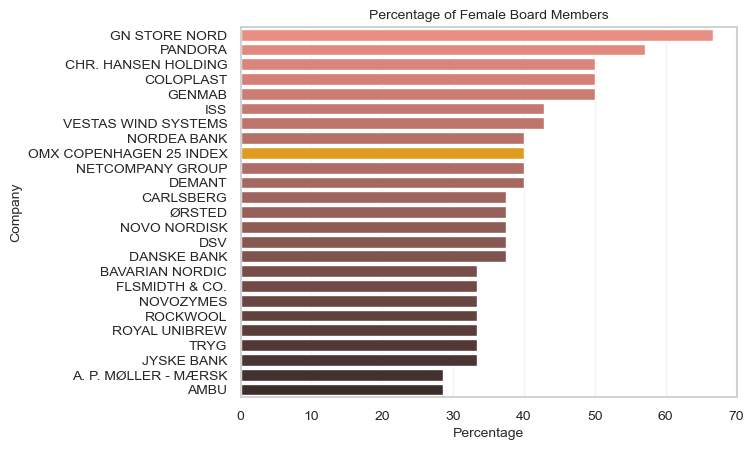

In [45]:
# set theme
sns.set(style="whitegrid")

# create custom color list

# create a list with n colors of dark:salmon_r
palette = list(sns.color_palette('dark:salmon_r', n_colors = len(C25F)))
# insert the color 'orange' in the list of colors using the index of C25
palette.insert(C25F[C25F['company'] == 'OMX COPENHAGEN 25 INDEX'].index[0], 'orange')

# create the bar chart with the custom palette
ax = sns.barplot(x='femaleboard', y='company', data=C25F, palette=palette) 

# change fontsize for all labels (plt.rcParams.update) do not affect this plot.
fontsize = 10

# set the title, labels and ticks
ax.set_title('Percentage of Female Board Members', fontsize = fontsize)
ax.set_xlabel('Percentage', fontsize = fontsize)
ax.set_ylabel('Company', fontsize = fontsize)

# change the font size of the x- and y-tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize = fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize)

# Show the plot
plt.show()

# Merge data sets

I calculate the expected monthly returns of each stock, `formula`.

In [58]:
# calculate expected monthly returns of each stock
hist_mark_emr = hist_mark_mr.mean()

# make hist_mark_emr into a pd.dataframe
hist_mark_emr = hist_mark_emr.to_frame(name = 'emr')

# display data
hist_mark_emr.head()


,emr
AMBU-B.CO,-0.002843
BAVA.CO,0.033489
CARL-B.CO,0.013592
CHR.CO,0.004572
COLO-B.CO,0.001363


Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

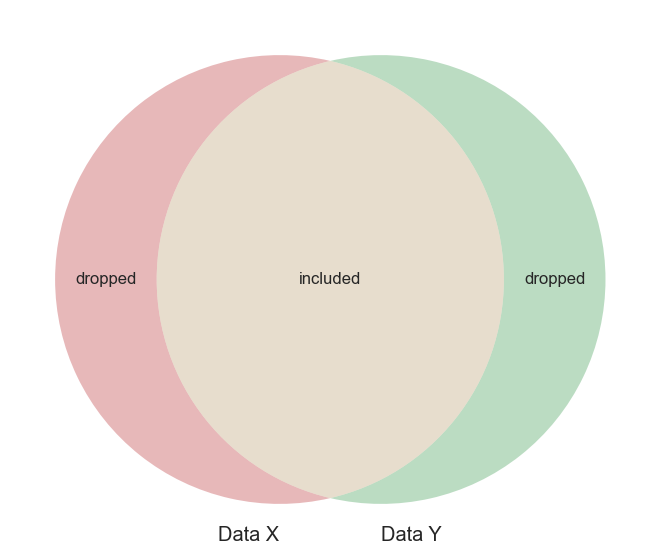

In [38]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.